In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# 设置随机种子
seed = 42
np.random.seed(seed)
random.seed(seed)

# 加载数据
data_path = '/Users/luolan/Desktop/S&P500_data.csv'
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# 确保时间索引是日期格式，并设置频率为工作日
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')
data = data.fillna(method='ffill').fillna(method='bfill')

# 计算技术指标
data['SMA_14'] = data['Close'].rolling(window=14).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['Signal_Line'] = calculate_macd(data)

def calculate_rsi(data, window):
    diff = data.diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['Close'], 14)

# 数据平滑处理
data['Close_Smoothed'] = data['Close'].rolling(window=5).mean().fillna(method='bfill')

# 删除包含NaN值的行
data = data.dropna()

In [3]:
# 按时间顺序拆分数据集
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 标准化数据
features = ['Open', 'High', 'Low', 'Close_Smoothed', 'Volume', 'SMA_14', 'SMA_50', 'SMA_200', 'MACD', 'Signal_Line', 'RSI']
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[features])
test_data_scaled = scaler.transform(test_data[features])

# 窗口大小
window_size = 30

# 创建特征和目标变量
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

train_sequences = create_sequences(train_data_scaled, window_size)
test_sequences = create_sequences(test_data_scaled, window_size)

X_train = train_sequences[:, :-1].reshape(len(train_sequences), -1)
y_train = train_sequences[:, -1, 3]  # 'Close_Smoothed' 列作为预测目标
X_test = test_sequences[:, :-1].reshape(len(test_sequences), -1)
y_test = test_sequences[:, -1, 3]  # 'Close_Smoothed' 列作为预测目标

# 构建SVM模型
svm_model = SVR(kernel='rbf', C=1.0, gamma='scale')

# 训练模型
svm_model.fit(X_train, y_train)

SVR()

In [4]:
# 进行预测
y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)

# 获取标准化时使用的均值和标准差
scaler_mean = scaler.mean_[3]  # 第四个特征 'Close_Smoothed' 对应的均值
scaler_scale = scaler.scale_[3]  # 第四个特征 'Close_Smoothed' 对应的标准差

# 对预测值进行逆标准化
y_train_pred_inverse = y_train_pred_svm * scaler_scale + scaler_mean
y_test_pred_inverse = y_test_pred_svm * scaler_scale + scaler_mean
y_train_inverse = y_train * scaler_scale + scaler_mean
y_test_inverse = y_test * scaler_scale + scaler_mean

# 计算逆标准化后的评估指标
mse_train_inverse = mean_squared_error(y_train_inverse, y_train_pred_inverse)
rmse_train_inverse = np.sqrt(mse_train_inverse)
mae_train_inverse = mean_absolute_error(y_train_inverse, y_train_pred_inverse)
r2_train_inverse = r2_score(y_train_inverse, y_train_pred_inverse)

print(f'Training Set Metrics (SVR)')
print(f'MSE: {mse_train_inverse}')
print(f'RMSE: {rmse_train_inverse}')
print(f'MAE: {mae_train_inverse}')
print(f'R²: {r2_train_inverse}')

mse_test_inverse = mean_squared_error(y_test_inverse, y_test_pred_inverse)
rmse_test_inverse = np.sqrt(mse_test_inverse)
mae_test_inverse = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
r2_test_inverse = r2_score(y_test_inverse, y_test_pred_inverse)

print(f'Test Set Metrics (SVR):')
print(f'MSE: {mse_test_inverse}')
print(f'RMSE: {rmse_test_inverse}')
print(f'MAE: {mae_test_inverse}')
print(f'R²: {r2_test_inverse}')

Training Set Metrics (SVR)
MSE: 2228.643896438179
RMSE: 47.20851508402038
MAE: 39.223264033410885
R²: 0.9965160604036385
Test Set Metrics (SVR):
MSE: 131358.8731429063
RMSE: 362.43464671980007
MAE: 226.67211625796463
R²: 0.426710239612753


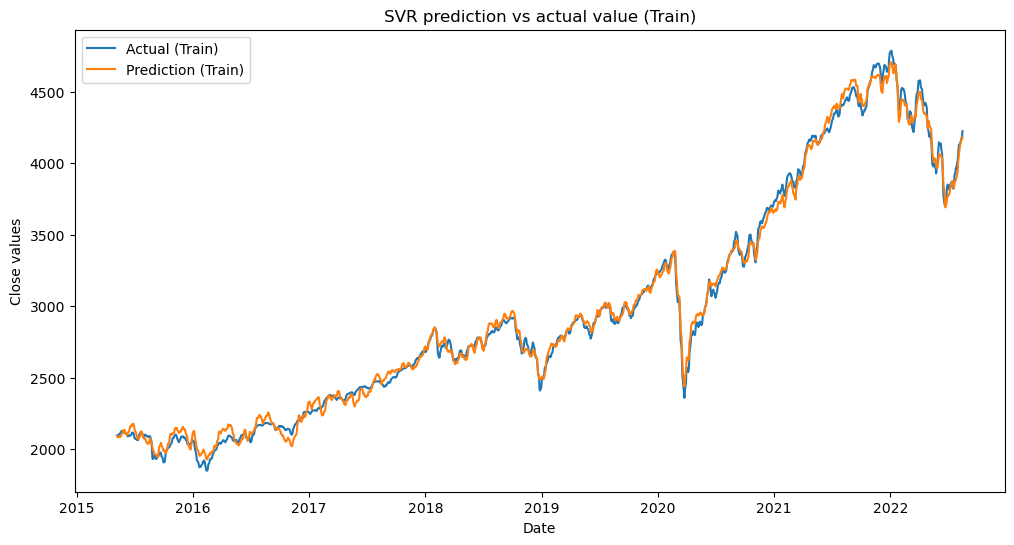

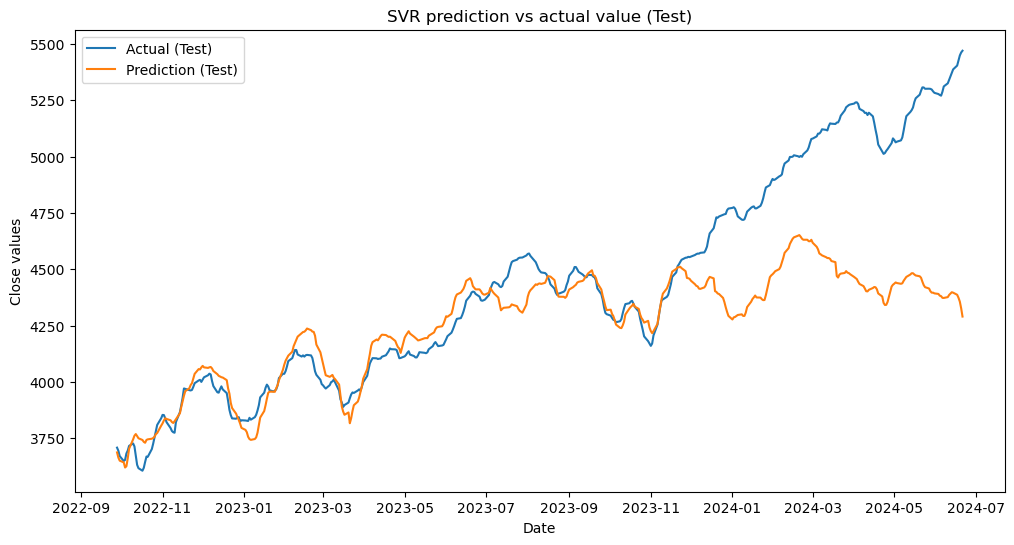

In [5]:
# 获取预测值对应的索引
train_index = train_data.index[window_size:window_size + len(y_train)]
test_index = test_data.index[window_size:window_size + len(y_test)]

# 绘制逆标准化后的训练集预测值与实际值对比图
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train_inverse, label='Actual (Train)')
plt.plot(train_index, y_train_pred_inverse, label='Prediction (Train)')
plt.title('SVR prediction vs actual value (Train)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

# 绘制逆标准化后的测试集预测值与实际值对比图
plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test_inverse, label='Actual (Test)')
plt.plot(test_index, y_test_pred_inverse, label='Prediction (Test)')
plt.title('SVR prediction vs actual value (Test)')
plt.xlabel('Date')
plt.ylabel('Close values')
plt.legend()
plt.show()

In [6]:
# 保存逆标准化后的预测结果到CSV文件
train_results = pd.DataFrame({'Actual': y_train_inverse, 'Prediction': y_train_pred_inverse})
test_results = pd.DataFrame({'Actual': y_test_inverse, 'Prediction': y_test_pred_inverse})

train_results.to_csv('modelSVR_train_predictions.csv', index=False)
test_results.to_csv('modelSVR_test_predictions.csv', index=False)

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 读取逆标准化后的预测结果
test_results = pd.read_csv('modelSVR_test_predictions.csv')

# 定义短期预测窗口（例如，10天）
short_term_window = 10

# 提取短期预测和实际值
short_term_actual = test_results['Actual'][:short_term_window]
short_term_predicted = test_results['Prediction'][:short_term_window]

# 计算短期预测的误差指标
mse_short_term = mean_squared_error(short_term_actual, short_term_predicted)
rmse_short_term = np.sqrt(mse_short_term)
mae_short_term = mean_absolute_error(short_term_actual, short_term_predicted)

print("短期预测的误差指标：")
print(f'MSE: {mse_short_term}')
print(f'RMSE: {rmse_short_term}')
print(f'MAE: {mae_short_term}')

# 计算短期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions = np.sum(np.abs(short_term_actual - short_term_predicted) <= error_margin * short_term_actual)
accuracy = accurate_predictions / len(short_term_actual)

print("短期预测的准确率：", accuracy)


短期预测的误差指标：
MSE: 1008.6710558232058
RMSE: 31.759582110336492
MAE: 28.106748202670634
短期预测的准确率： 1.0


In [8]:
# 定义长期预测窗口（例如，30天）
long_term_window = 730

# 提取长期预测和实际值
long_term_actual = test_results['Actual'][:long_term_window]
long_term_predicted = test_results['Prediction'][:long_term_window]

# 计算长期预测的误差指标
mse_long_term = mean_squared_error(long_term_actual, long_term_predicted)
rmse_long_term = np.sqrt(mse_long_term)
mae_long_term = mean_absolute_error(long_term_actual, long_term_predicted)

print("长期预测的误差指标：")
print(f'MSE: {mse_long_term}')
print(f'RMSE: {rmse_long_term}')
print(f'MAE: {mae_long_term}')

# 计算长期预测的准确率（定义误差范围为±5%）
error_margin = 0.05  # 误差范围±5%
accurate_predictions_long_term = np.sum(np.abs(long_term_actual - long_term_predicted) <= error_margin * long_term_actual)
accuracy_long_term = accurate_predictions_long_term / len(long_term_actual)

print("长期预测的准确率：", accuracy_long_term)

长期预测的误差指标：
MSE: 131358.8731429063
RMSE: 362.43464671980007
MAE: 226.67211625796463
长期预测的准确率： 0.6975717439293598


Final portfolio value: $12845.25
Maximum Drawdown: $492.32
Sharpe Ratio: 4.57
Win Rate: 86.67%
Total Trades: 31
Annualized Return: 14.95%


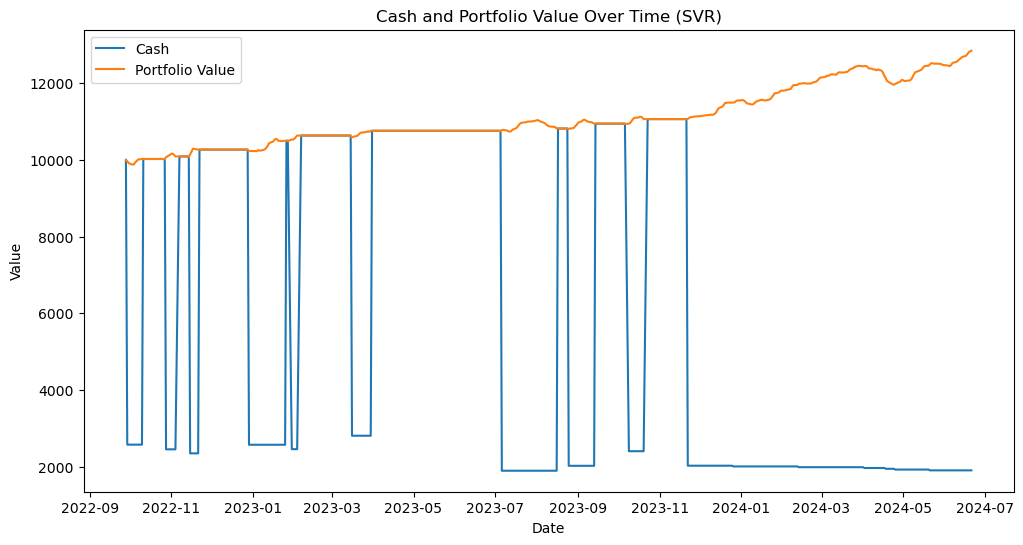

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化变量
initial_cash = 10000
shares = 0
cash_history = [initial_cash]
portfolio_value_history = []
trades = 0
profits = []
transaction_cost = 0.001  # 交易成本假设为0.1%
previous_price = 0

# 止盈和止损设置
take_profit_threshold = 0.05  # 止盈5%
stop_loss_threshold = 0.02  # 止损2%
min_hold_period = 5  # 最小持有期（以天为单位）
hold_period = 0

# 交易模拟（假设在预测值大于实际值时卖出，小于实际值时买入）
for i in range(len(y_test_inverse)):
    current_price = y_test_inverse[i]
    predicted_price = y_test_pred_inverse[i]

    # 持有股票且达到最小持有期后才检查止盈和止损
    if shares > 0 and hold_period >= min_hold_period:
        current_return = (current_price - previous_price) / previous_price
        if current_return >= take_profit_threshold or current_return <= -stop_loss_threshold:
            trades += 1
            initial_cash += shares * current_price * (1 - transaction_cost)
            profits.append(shares * (current_price - previous_price) * (1 - transaction_cost))
            shares = 0
            hold_period = 0

    # 卖出条件
    if predicted_price > current_price and shares > 0 and hold_period >= min_hold_period:
        trades += 1
        initial_cash += shares * current_price * (1 - transaction_cost)
        if previous_price != 0:
            profits.append(shares * (current_price - previous_price) * (1 - transaction_cost))
        shares = 0
        hold_period = 0
    
    # 买入条件
    elif predicted_price < current_price and initial_cash >= current_price:
        trades += 1
        shares_to_buy = initial_cash // current_price
        previous_price = current_price
        initial_cash -= shares_to_buy * current_price * (1 + transaction_cost)
        shares += shares_to_buy
        hold_period = 0
    
    # 更新持有期
    hold_period += 1

    # 记录当前现金和总资产值
    cash_history.append(initial_cash)
    portfolio_value = initial_cash + shares * current_price
    portfolio_value_history.append(portfolio_value)

# 修正长度以匹配test_index
cash_history = cash_history[:-1]

# 计算最终的资产值
final_value = initial_cash + shares * y_test_inverse[-1]
print(f'Final portfolio value: ${final_value:.2f}')

# 计算最大回撤
drawdown = [max(portfolio_value_history[:i+1]) - portfolio_value_history[i] for i in range(len(portfolio_value_history))]
max_drawdown = max(drawdown)
print(f'Maximum Drawdown: ${max_drawdown:.2f}')

# 计算夏普比率
returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
annualized_return = np.mean(returns) * 252
annualized_volatility = np.std(returns) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# 计算胜率
win_rate = sum([1 for profit in profits if profit > 0]) / len(profits) if profits else 0
print(f'Win Rate: {win_rate:.2%}')

# 计算交易次数
print(f'Total Trades: {trades}')

# 计算年化收益率
days = len(y_test_inverse)  # 确认这是实际的交易天数
initial_cash = 10000

# 计算总收益率
total_return = final_value / initial_cash - 1

# 计算年化收益率
annualized_return_percentage = (1 + total_return) ** (252 / days) - 1
annualized_return_percentage = annualized_return_percentage * 100
print(f'Annualized Return: {annualized_return_percentage:.2f}%')

# 绘制现金和资产总值的变化情况
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window_size:][:len(cash_history)], cash_history, label='Cash')
plt.plot(test_data.index[window_size:][:len(portfolio_value_history)], portfolio_value_history, label='Portfolio Value')
plt.title('Cash and Portfolio Value Over Time (SVR)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()